## Understanding the Amazon from Space
This notebook will show you how to do some basic manipulation of the images and label files.

In [1]:
import sys
import os
from os.path import exists
import subprocess

from six import string_types

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [2]:
!ls -lha ~/input

total 11M
drwxrwxr-x  9 ubuntu ubuntu 4.0K May 12 21:30 .
drwxr-xr-x 20 ubuntu ubuntu 4.0K May 12 21:32 ..
-rwxrwxr-x  1 ubuntu ubuntu 2.8M May  9 02:58 sample_submission_v2.csv
drwxrwxr-x  2 ubuntu ubuntu 1.4M Apr 19 22:08 test-jpg
drwxrwxr-x  2 ubuntu ubuntu 664K May  4 17:12 test-jpg-additional
drwxrwxr-x  2 ubuntu ubuntu 2.1M May  6 04:02 test-tif-v2
drwxrwxr-x  2 ubuntu ubuntu 1.4M Apr 19 21:59 train-jpg
drwxrwxr-x  2 ubuntu ubuntu 4.0K Apr 21 23:44 train-jpg-sample
drwxrwxr-x  2 ubuntu ubuntu 4.0K Apr 20 01:22 train-tif-sample
drwxrwxr-x  2 ubuntu ubuntu 1.4M May  1 20:16 train-tif-v2
-rwxrwxr-x  1 ubuntu ubuntu 1.4M May  9 02:52 train_v2.csv


### Setup
Set PLANET_KAGGLE_ROOT to the proper directory where we've got the TIFF and JPEG zip files, and accompanying CSVs.

In [3]:
!ls -lha ~/input/train-jpg | wc -l

40482


## Inspect image labels
The labels are in a CSV entitled train.csv. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [4]:
PLANET_KAGGLE_ROOT = "/home/ubuntu/input"
PLANET_KAGGLE_JPG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [5]:
!ls -lha ~/input/train_v2.csv

-rwxrwxr-x 1 ubuntu ubuntu 1.4M May  9 02:52 /home/ubuntu/input/train_v2.csv


In [6]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [8]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


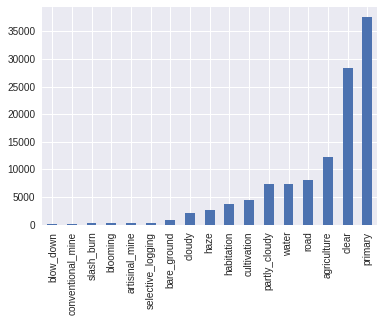

In [9]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


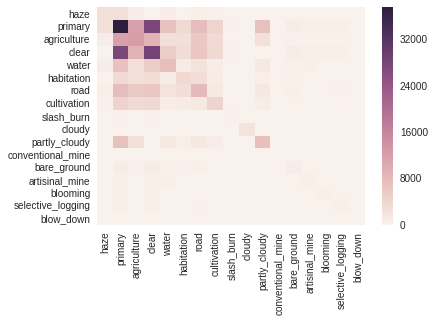

In [10]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


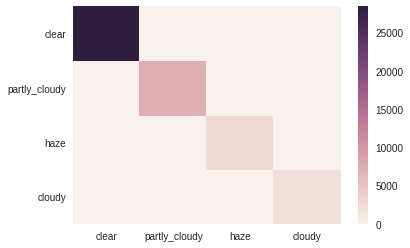

In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


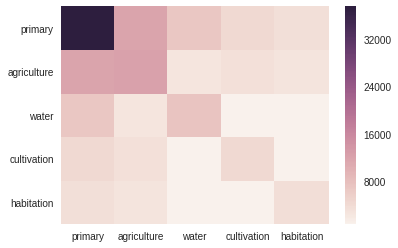

In [12]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


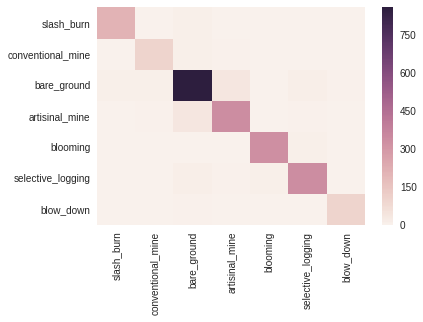

In [13]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

### Inspect images
Let's display an image and visualize the pixel values. Here we will pick an image, load every single single band, then create RGB stack. These raw images are 16-bit (from 0 to 65535), and contain red, green, blue, and Near infrared (NIR) channels. In this example, we are discarding the NIR band just to simplify the steps to visualize the image. However, you should probably keep it for ML classification.
The files can be easily read into numpy arrays with the skimage.

In [14]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [15]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='tif'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

Let's look at an individual image. First, we'll plot a histogram of pixel values in each channel. Note how the intensities are distributed in a relatively narrow region of the dynamic range

In [16]:
def plot_rgbn_histo(r, g, b, n):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

Found image /home/ubuntu/input/train-tif-v2/train_25199.tif


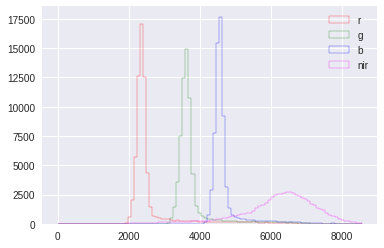

In [17]:
s = sample_images(['primary', 'artisinal_mine'], n=1)
fname = sample_to_fname(s, 0)

# find the image in the data directory and load it
# note the initial bgrn band ordering
bgrn_image = load_image(fname)

# extract the rgb values
bgr_image = bgrn_image[:,:,:3]
rgb_image = bgr_image[:, :, [2,1,0]]

# extract the different bands
b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 3]

# plot a histogram of rgbn values
plot_rgbn_histo(r, g, b, nir)

We can look at each channel individually:

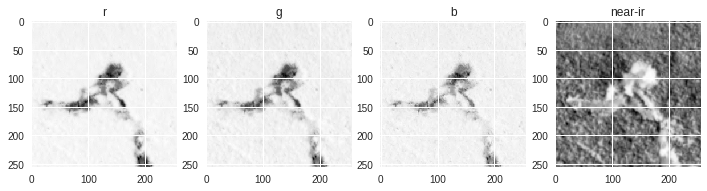

In [18]:
#Plot the bands
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

But, when we try to look at the RGB image, something funny's going on!|

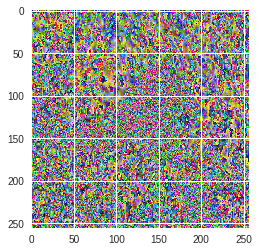

In [19]:
plt.imshow(rgb_image)

### Calibrate colors for visual inspection
Yikes! That does not look pretty. This is not a problem for analytic purposes, but we can try some transformations to make the image look better for visual inspection.

One way of doing this is to normalize the image channels to a reference color curve. We'll show here how to estimate a reference color curve from other normalized images. We could choose a third party aerial image of a canopy , but here we will employ the JPEG images provided in the data set, which have already been color-corrected.

In essence, the idea is to transform the pixel values of the test image so that their average and variance match the reference image data.

Get a list of reference images to extract data from:

In [20]:
#pull a list of 20000 image names
jpg_list = os.listdir(PLANET_KAGGLE_JPG_DIR)[:20000]
# Select a random number of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]

In [21]:
print (jpg_list)

['train_32787.jpg', 'train_33890.jpg', 'train_8452.jpg', 'train_32583.jpg', 'train_17659.jpg', 'train_12520.jpg', 'train_15349.jpg', 'train_11545.jpg', 'train_25793.jpg', 'train_33681.jpg', 'train_15096.jpg', 'train_12017.jpg', 'train_38713.jpg', 'train_3230.jpg', 'train_15885.jpg', 'train_35767.jpg', 'train_9665.jpg', 'train_17462.jpg', 'train_13361.jpg', 'train_25812.jpg', 'train_20303.jpg', 'train_37178.jpg', 'train_31291.jpg', 'train_16367.jpg', 'train_13493.jpg', 'train_21718.jpg', 'train_19705.jpg', 'train_38090.jpg', 'train_5167.jpg', 'train_13843.jpg', 'train_26717.jpg', 'train_30138.jpg', 'train_283.jpg', 'train_15948.jpg', 'train_14010.jpg', 'train_18804.jpg', 'train_21338.jpg', 'train_15380.jpg', 'train_31636.jpg', 'train_13835.jpg', 'train_23424.jpg', 'train_27769.jpg', 'train_28798.jpg', 'train_28440.jpg', 'train_3719.jpg', 'train_39880.jpg', 'train_26755.jpg', 'train_20431.jpg', 'train_19912.jpg', 'train_14378.jpg', 'train_37266.jpg', 'train_25895.jpg', 'train_26409.jpg',

Read each image (8-bit RGBA) and dump the pixels values to ref_colors, which contains buckets for R, G and B

In [22]:
ref_colors = [[], [], []]
for _file in jpg_list:
    #keep only the first three bands, RGB
    _img = mpimg.imread(os.path.join(PLANET_KAGGLE_JPG_DIR, _file))[:,:,:3]
    # Flatten 2D to 1D
    _data = _img.reshape((-1,3))
    # Dump pixel  values to aggregation buckets
    for i in range(3):
        ref_colors[i] = ref_colors[i] + _data[:,i].tolist()
        
ref_colors = np.array(ref_colors)

Visualize the histogram of the reference data

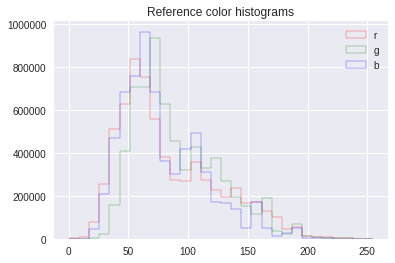

In [23]:
for i,color in enumerate(['r','g','b']):
    plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Reference color histograms')

Compute the mean and variance for each channel in the reference data

In [24]:
ref_means = [np.mean(ref_colors[i]) for i in range(3)]
ref_stds = [np.std(ref_colors[i]) for i in range(3)]

And now, we have a function that can calibrate any raw image reasonably well:

In [25]:
def calibrate_image(rgb_image):
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it 
    calibrated_img = rgb_image.copy().astype('float32')

    # Loop over RGB
    for i in range(3):
        # Subtract mean 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        # Scale to reference 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)

    # Convert to 8-bit unsigned int
    return calibrated_img.astype('uint8')

Visualize the color histogram of the newly calibrated test image, and note that it's more evenly distributed throughout the dynamic range, and is closer to the reference data.

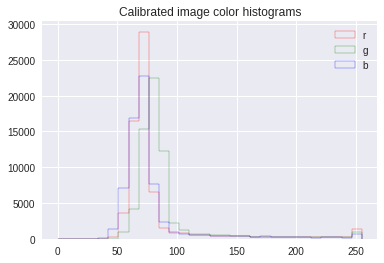

In [26]:
test_image_calibrated = calibrate_image(rgb_image)
for i,color in enumerate(['r','g','b']):
    plt.hist(test_image_calibrated[:,:,i].ravel(), bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Calibrated image color histograms')

Now let's see what we have here

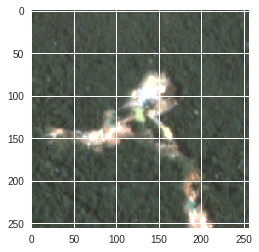

In [27]:
plt.imshow(test_image_calibrated)

Putting it all together, to show several images with your tags of choice. You may notice that the jpgs and tifs look a bit different. 

Found image /home/ubuntu/input/train-tif-v2/train_9519.tif
Found image /home/ubuntu/input/train-jpg/train_9519.jpg
Found image /home/ubuntu/input/train-tif-v2/train_31313.tif
Found image /home/ubuntu/input/train-jpg/train_31313.jpg
Found image /home/ubuntu/input/train-tif-v2/train_2043.tif
Found image /home/ubuntu/input/train-jpg/train_2043.jpg


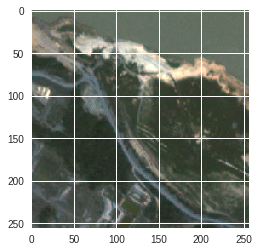

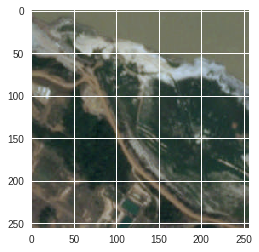

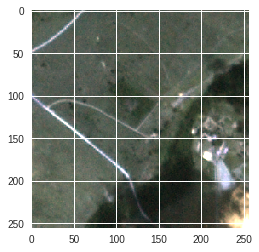

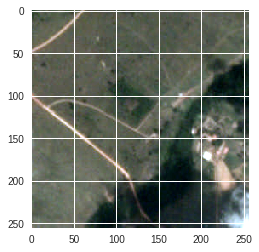

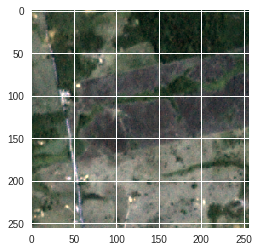

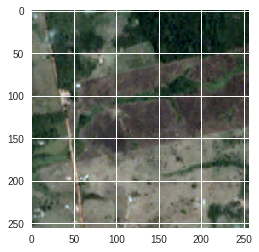

In [35]:
sampled_images = sample_images(['primary', 'agriculture', 'road', 'water'], n=3)

for i in range(len(sampled_images)):
    tif = sample_to_fname(sampled_images, i, 'tif')
    jpg = sample_to_fname(sampled_images, i, 'jpg')
    
    try:
        tif_img = load_image(tif)[:,:,:3]
        jpg_img = load_image(jpg)[:,:,:3]
        
        fig = plt.figure()
        plt.imshow(calibrate_image(tif_img))
        
        fig = plt.figure()
        plt.imshow(calibrate_image(jpg_img))
        
    except:
        continue